# Data Exploration in Splice Machine
<blockquote><p class='quotation'><span style='font-size:15px'> Data exploration couldn't be easier on Splice. Our build in, scalable Spark Sessions allow you do run massive analytics, and our robust library support removes the learning curve. In this notebook, we'll ingest our SQL table into a Spark Dataframe using the Native Spark Datasource, and then use <code>Koalas</code> to give us Pandas API syntax on distributed Spark Dataframes! <a href=https://koalas.readthedocs.io/en/latest/getting_started/index.html>Koalas</a> is a powerful library and removes the need to learn PySpark syntax to run large scale analytics on your data.<br>

In order to use Koalas (or any other custom library you'd like), simply <code>pip install</code> right in a notebook. If importing koalas fails after the install, you may need to restart the kernel after installing:
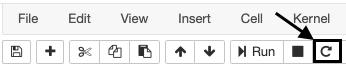

Then, simply import the library and you're ready to go!<br><br>
Note: If you've already installed Koalas in another notebook (or in a terminal session), you won't need to reinstall it.
<footer>Splice Machine</footer>


In [1]:
!pip install koalas

     |████████████████████████████████| 630 kB 2.7 MB/s eta 0:00:01


#### Let's start our Spark Session

In [3]:
# Setup
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

import databricks.koalas as ks
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
from splicemachine.mlflow_support.utilities import get_user

spark = SparkSession.builder.getOrCreate()
splice = PySpliceContext(spark)
schema = get_user()

## Ingesting Data
<blockquote><p class='quotation'><span style='font-size:15px'> There are a variety of ways to ingest data into Splice Machine. here we'll use the built in <code>IMPORT_DATA</code> SQL function to bring data from s3 directly into a Splice Machine table. From there we'll be able to investigate our features. <footer>Splice Machine</footer>
</blockquote>

In [4]:
%%sql
drop table if exists cc_fraud_data; 
create table cc_fraud_data (
    time_offset integer,
    expected_weekly_trans_cnt double,
    expected_weekly_trans_amnt double,
    expected_daily_trans_cnt double,
    expected_daily_trans_amnt double,
    weekly_trans_cnt double,
    weekly_trans_amnt double,
    daily_trans_cnt double,
    daily_trans_amnt double,
    rolling_avg_weekly_trans_cnt double,
    rolling_avg_weekly_trans_amnt double,
    rolling_avg_daily_trans_cnt double,
    rolling_avg_daily_trans_amnt double,
    MACD_trans_amnt double,
    MACD_trans_cnt double,
    RSI_trans_amnt double,
    RSI_trans_cnt double,
    Aroon_trans_amnt double,
    Aroon_trans_cnt double,
    ADX_trans_amnt double,
    ADX_trans_cnt double,
    current_balance double,
    rolling_avg_balance double,
    MACD_balance double,
    Aroon_balance double,
    RSI_balance double,
    ADX_balance double,
    credit_score double,
    credit_limit double,
    amount decimal(10,2),
    class_result int
);

call SYSCS_UTIL.IMPORT_DATA (
     null,
     'cc_fraud_data',
     null,
     's3a://splice-demo/kaggle-fraud-data/creditcard.csv',
     ',',
     null,
     null,
     null,
     null,
     -1,
     's3a://splice-demo/kaggle-fraud-data/bad',
     null, 
     null);
     

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sql started successfully



## We can use `SQL` natively to investigate our data

In [7]:
%%sql
-- Get the class distribution of our label
select class_result, count(*) as NUM_Occurrences
from cc_fraud_data 
group by class_result

In [8]:
%%sql 
-- Calculate averages for some important metrics
SELECT class_result, AVG(expected_weekly_trans_cnt) as avg_expected_weekly_trans_cnt, 
AVG(MACD_trans_amnt) as avg_MACD_trans_amnt, 
AVG(RSI_trans_amnt) as avg_RSI_trans_amnt
from cc_fraud_data
group by class_result

## Using the Native Spark Data Source (and Koalas) to get our data in PySpark

In [43]:
df = splice.df(f"SELECT * FROM {schema}.cc_fraud_data").to_koalas().astype({'AMOUNT': 'float64'})
df

,TIME_OFFSET,EXPECTED_WEEKLY_TRANS_CNT,EXPECTED_WEEKLY_TRANS_AMNT,EXPECTED_DAILY_TRANS_CNT,EXPECTED_DAILY_TRANS_AMNT,WEEKLY_TRANS_CNT,WEEKLY_TRANS_AMNT,DAILY_TRANS_CNT,DAILY_TRANS_AMNT,ROLLING_AVG_WEEKLY_TRANS_CNT,ROLLING_AVG_WEEKLY_TRANS_AMNT,ROLLING_AVG_DAILY_TRANS_CNT,ROLLING_AVG_DAILY_TRANS_AMNT,MACD_TRANS_AMNT,MACD_TRANS_CNT,RSI_TRANS_AMNT,RSI_TRANS_CNT,AROON_TRANS_AMNT,AROON_TRANS_CNT,ADX_TRANS_AMNT,ADX_TRANS_CNT,CURRENT_BALANCE,ROLLING_AVG_BALANCE,MACD_BALANCE,AROON_BALANCE,RSI_BALANCE,ADX_BALANCE,CREDIT_SCORE,CREDIT_LIMIT,AMOUNT,CLASS_RESULT
0,78123,1.242281,0.199481,0.173321,0.642029,-0.483888,-1.390820,0.287118,-0.296766,-0.008904,-0.018249,-0.127030,-0.062092,-0.700882,0.566435,0.853531,-0.054381,-0.116866,-0.530573,-0.200180,-0.135933,-0.041422,-0.148216,-0.016139,0.747942,0.475955,0.453556,-0.066222,0.008288,16.11,0
1,78878,-0.438668,1.047467,1.703435,0.046779,-0.225900,-1.094178,0.697298,-0.082498,-0.406396,-0.308439,-0.118538,0.023341,-0.093484,0.175333,0.831681,0.105760,-0.270247,-0.451177,-0.108440,0.080611,-0.207559,-0.540343,0.017062,0.690734,-0.240261,0.051245,0.265558,0.124202,1.29,0
2,79463,-2.202675,-0.892593,0.436432,1.523907,0.764082,-1.593149,0.016452,0.018566,-0.768651,0.139917,-0.022497,0.932562,1.822730,0.274698,1.570900,-0.305661,0.234357,-0.669435,2.009051,-0.667445,-0.582835,-0.767617,1.938239,0.403147,-0.580063,0.163953,0.129860,-0.169588,19.95,0
3,80202,-0.667916,1.173351,1.445143,-0.074864,-0.135110,-0.909599,0.717203,-0.059633,-0.201283,-0.007863,-0.378637,-0.054311,0.008714,0.076921,0.868737,0.182148,-0.401531,-0.364027,-0.017252,0.229494,-0.257729,-0.619964,0.001367,0.361930,-0.140388,0.076004,0.371646,0.186613,13.23,0
4,81079,1.118055,-0.114411,0.519357,1.102106,-0.344508,0.385339,-0.389015,0.361145,0.607521,0.021051,0.516438,-0.056129,-2.443876,0.607243,-0.324819,-0.159664,-0.032878,-0.107344,0.118952,-0.300695,-0.235219,-0.625905,0.041126,-0.381279,0.356547,-0.505420,0.035960,0.007233,12.99,0
5,82006,-1.191579,0.903180,0.894544,1.163632,0.115606,0.515655,0.419514,0.476832,-0.306147,0.345808,0.704192,0.653904,-0.437592,0.302314,-0.389144,-0.862840,0.328872,-0.037661,1.102610,0.256133,-0.047546,0.262384,-0.196764,-0.299316,-0.043236,-0.242023,0.285553,-0.085012,67.70,0
6,83032,0.906048,-1.489041,0.128104,-0.347110,-1.283634,-0.398318,-0.350602,-0.125511,-0.262666,0.374267,-1.145961,-0.857525,-0.543471,-0.338443,-0.267612,0.887216,0.514374,-1.474700,1.049381,0.556757,0.031580,-0.466646,-0.255772,-0.109451,0.384655,-0.327455,-0.034576,0.056991,275.00,0
7,84160,-1.336993,0.376450,-0.047985,-4.241668,1.885544,2.804898,-0.284731,1.378162,0.702920,-2.069414,-0.362542,0.270904,-0.104636,0.345874,0.931900,0.761305,-1.203282,0.624445,-0.660250,0.034619,0.108535,0.059920,-0.359737,1.035079,0.859901,-0.097734,0.120560,0.025450,21.29,0
8,85201,-2.405464,-2.377169,1.529087,-0.981799,-1.699544,0.687757,-0.189862,0.920944,-0.478634,-0.807546,0.179119,-0.409726,-1.641830,-0.338313,-2.175769,0.871728,0.856624,-0.861067,0.127457,0.979130,0.704138,0.942530,0.655924,0.012077,0.345347,-0.155340,-0.125197,-0.124788,412.00,0
9,86787,-0.342349,0.969487,1.249645,-0.415257,0.662142,-0.833470,1.290084,-0.528115,-0.494551,-0.422962,-0.496235,0.535804,1.175133,-0.317322,-0.019594,-0.446204,-0.298008,-0.865794,0.577651,0.104632,-0.329545,-0.748952,-0.287475,0.084429,0.532643,0.360187,-0.414061,-0.288067,1.98,0


## Let's use Koalas
<blockquote><p class='quotation'><span style='font-size:15px'> Now that we have our Koalas dataframe, we can use standard Pandas API, but distribute it all on Spark. Let's try some standard functions, and inspect what Koalas is doing under the hood <footer>Splice Machine</footer>
</blockquote>

In [44]:
# Sort by amount spent in transaction, looking at Amount, Current balance, and Weekly Transaction count
df.sort_values(by='AMOUNT', ascending=False)[['AMOUNT','CURRENT_BALANCE', 'WEEKLY_TRANS_CNT']]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,AMOUNT,CURRENT_BALANCE,WEEKLY_TRANS_CNT
109892,25691.16,-21.620120,-113.743307
156537,19656.53,11.455313,-20.672064
268089,18910.00,11.502580,-19.229075
248725,12910.93,7.921600,-13.945538
107744,11898.09,7.437478,-12.880794
230414,11789.84,6.829810,-10.866639
3431,10199.44,-0.269048,-40.427726
256582,10000.00,5.198718,3.957175
262196,8790.26,-5.932594,-27.752964
223426,8787.00,5.788207,-7.855074


In [45]:
# See rows with WEEKLY_TRANS_AMNT above 25
df[df['WEEKLY_TRANS_AMNT'] > 18]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TIME_OFFSET,EXPECTED_WEEKLY_TRANS_CNT,EXPECTED_WEEKLY_TRANS_AMNT,EXPECTED_DAILY_TRANS_CNT,EXPECTED_DAILY_TRANS_AMNT,WEEKLY_TRANS_CNT,WEEKLY_TRANS_AMNT,DAILY_TRANS_CNT,DAILY_TRANS_AMNT,ROLLING_AVG_WEEKLY_TRANS_CNT,ROLLING_AVG_WEEKLY_TRANS_AMNT,ROLLING_AVG_DAILY_TRANS_CNT,ROLLING_AVG_DAILY_TRANS_AMNT,MACD_TRANS_AMNT,MACD_TRANS_CNT,RSI_TRANS_AMNT,RSI_TRANS_CNT,AROON_TRANS_AMNT,AROON_TRANS_CNT,ADX_TRANS_AMNT,ADX_TRANS_CNT,CURRENT_BALANCE,ROLLING_AVG_BALANCE,MACD_BALANCE,AROON_BALANCE,RSI_BALANCE,ADX_BALANCE,CREDIT_SCORE,CREDIT_LIMIT,AMOUNT,CLASS_RESULT
3431,172273,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,-7.776435,0.214173,-4.499851,0.241005,0.537895,2.901938,2.326099,-0.402142,1.257379,2.008145,2.454553,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0
84071,32605,-23.383129,-18.098804,-20.195367,4.249104,-42.147898,22.529298,36.677268,-4.862800,1.645619,-7.761890,-0.051013,-0.023820,3.027414,-0.504989,2.032532,6.098529,-0.205514,-1.031321,0.220769,-13.694584,-5.893230,-0.139751,-6.086173,1.924973,0.669689,0.449781,11.135740,-9.617915,7429.15,0
93380,142019,-37.558067,-29.335992,-24.962322,8.413616,-35.182120,21.550496,36.877368,-8.915982,5.046566,0.909474,3.919686,-0.384260,4.316156,-3.113694,5.667667,8.289890,-2.490935,-3.570907,1.663899,-28.009635,-11.263235,-1.150828,-7.800902,1.272716,1.965365,0.767817,3.248189,13.013546,5964.95,0
109892,166198,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,-12.005487,6.853897,-9.189418,7.126883,-6.795942,8.877742,17.315112,-7.173805,-1.968044,5.501747,-54.497720,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0
139956,67676,-7.103082,-1.706830,-9.726332,1.657590,-31.356750,20.379524,29.205868,-5.498667,-1.369680,-3.713841,2.212401,-1.534510,0.816452,-1.187157,0.949474,4.594817,-1.560379,-0.739444,-2.004658,-8.817441,-2.719498,0.876382,-2.041865,0.603670,0.321988,1.268208,5.868242,-4.071666,6239.54,0
173075,132779,-4.389647,-1.993089,-12.627453,0.282311,-29.730600,21.307738,31.527244,-6.354233,-0.293293,-3.399167,1.811068,-1.721828,0.787292,-1.516869,0.654465,2.797421,-1.660478,-1.636735,-0.468863,-10.347328,-3.801492,1.757957,-2.139086,-0.025463,-1.914228,0.275607,4.655054,-1.398364,6454.74,0
227378,1264,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,3.702177,-1.843056,2.427123,-1.652836,3.635042,4.087802,-1.654892,-0.888406,0.752276,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43,0
245568,122452,-12.564969,-7.021368,-11.587432,1.988852,-28.815577,21.190194,26.249717,-10.825664,2.961064,-2.436706,1.477686,-0.565587,1.220322,-3.256503,0.308272,4.188611,-1.388924,-1.615656,-0.051057,-17.970675,-1.360000,0.949443,-2.165378,-0.449718,-0.346792,0.837145,5.058448,2.435250,5918.00,0
262196,55709,-16.950064,-16.417395,-12.523381,6.555638,-27.752964,18.072031,28.504065,-10.152220,2.124673,-2.856014,0.121804,-1.619834,2.231107,-3.041540,2.630401,5.000096,-1.745472,-1.129167,2.639624,-19.902611,-5.932594,0.050097,-10.855949,1.550407,-0.502172,0.821714,12.152401,-4.009839,8790.26,0


In [46]:
# See what Koalas is doing under the hood
df[df['WEEKLY_TRANS_AMNT'] > 18].spark.explain()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


== Physical Plan ==
*(3) Project [(cast(_we0#6083 as bigint) - 1) AS __index_level_0__#6081L, TIME_OFFSET#6018, EXPECTED_WEEKLY_TRANS_CNT#6019, EXPECTED_WEEKLY_TRANS_AMNT#6020, EXPECTED_DAILY_TRANS_CNT#6021, EXPECTED_DAILY_TRANS_AMNT#6022, WEEKLY_TRANS_CNT#6023, WEEKLY_TRANS_AMNT#6024, DAILY_TRANS_CNT#6025, DAILY_TRANS_AMNT#6026, ROLLING_AVG_WEEKLY_TRANS_CNT#6027, ROLLING_AVG_WEEKLY_TRANS_AMNT#6028, ROLLING_AVG_DAILY_TRANS_CNT#6029, ROLLING_AVG_DAILY_TRANS_AMNT#6030, MACD_TRANS_AMNT#6031, MACD_TRANS_CNT#6032, RSI_TRANS_AMNT#6033, RSI_TRANS_CNT#6034, AROON_TRANS_AMNT#6035, AROON_TRANS_CNT#6036, ADX_TRANS_AMNT#6037, ADX_TRANS_CNT#6038, CURRENT_BALANCE#6039, ROLLING_AVG_BALANCE#6040, ... 8 more fields]
+- *(3) Filter CASE WHEN isnull(CASE WHEN isnull((WEEKLY_TRANS_AMNT#6024 > 18.0)) THEN false ELSE (WEEKLY_TRANS_AMNT#6024 > 18.0) END) THEN false ELSE CASE WHEN isnull((WEEKLY_TRANS_AMNT#6024 > 18.0)) THEN false ELSE (WEEKLY_TRANS_AMNT#6024 > 18.0) END END
   +- Window [row_number() windows

## Great! Let's do some investigation
<blockquote><p class='quotation'><span style='font-size:15px'>Now that we see the power of Koalas, let's use it! We'll look at some feature correlations and distributions without having to sample our data.<footer>Splice Machine</footer>
</blockquote>

## Investigating the correlation among our features

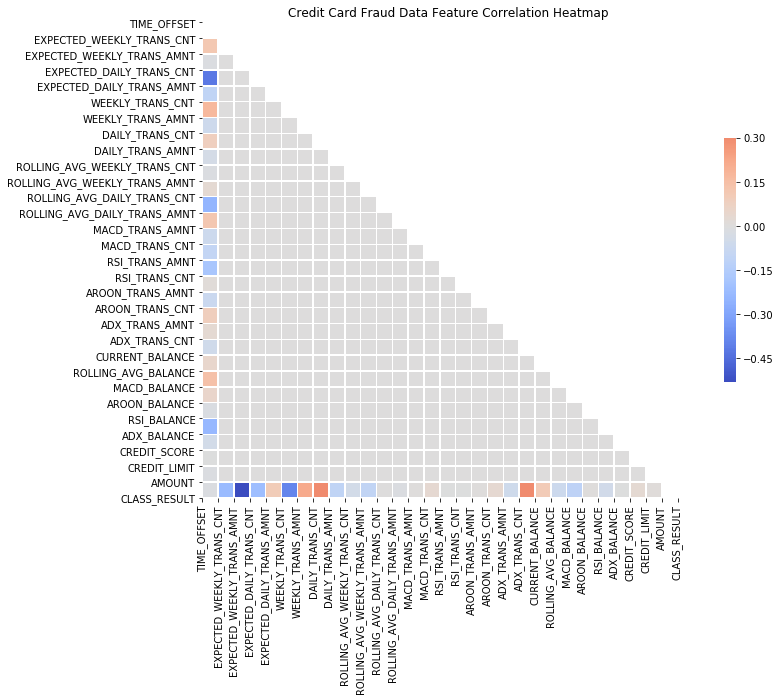

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

corr = df.corr().to_pandas()

ticks = [i for i in range(len(corr.columns))]
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = "coolwarm"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(ticks, corr.columns)
plt.yticks(ticks, corr.columns)
plt.title('Credit Card Fraud Data Feature Correlation Heatmap')
plt.show()

## Investigating the distribution of our features

In [60]:
features = list(df.columns)
features.remove("CLASS_RESULT")

## @Nirek, maybe use pyspark_dist_explore? It's v easy

<code>
    from pyspark_dist_explore import hist, distplot
    import matplotlib.pyplot as plt
    from pyspark.sql.types import DoubleType
    from matplotlib.ticker import FormatStrFormatter
    import matplotlib as mpl
    %matplotlib inline     
    mpl.style.use('seaborn')
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,10))
    cols = train_df.columns
    cols.remove(label_col)
    cols.remove('TRANSACTION_TS')
    cols.remove('TRANSACTION_ID')
    # show_df = train_df.sample(False, 0.01, seed=0)
    show_df = train_df.repartition(500) # .limit(1000)
    for i,f in enumerate(avl_features):
        row = i%2
        col = i//2
        distplot(axes[row,col], show_df.select(f.name), bins = 20, color=['lightblue'])
        axes[row,col].set_xlabel(f.name)
        axes[row,col].set_xticks([])
        axes[row,col].set_yticks([round(t,7) for t in axes[row,col].get_yticks()])
    </code>

PandasNotImplementedError: The method `pd.Series.__iter__()` is not implemented. If you want to collect your data as an NumPy array, use 'to_numpy()' instead.

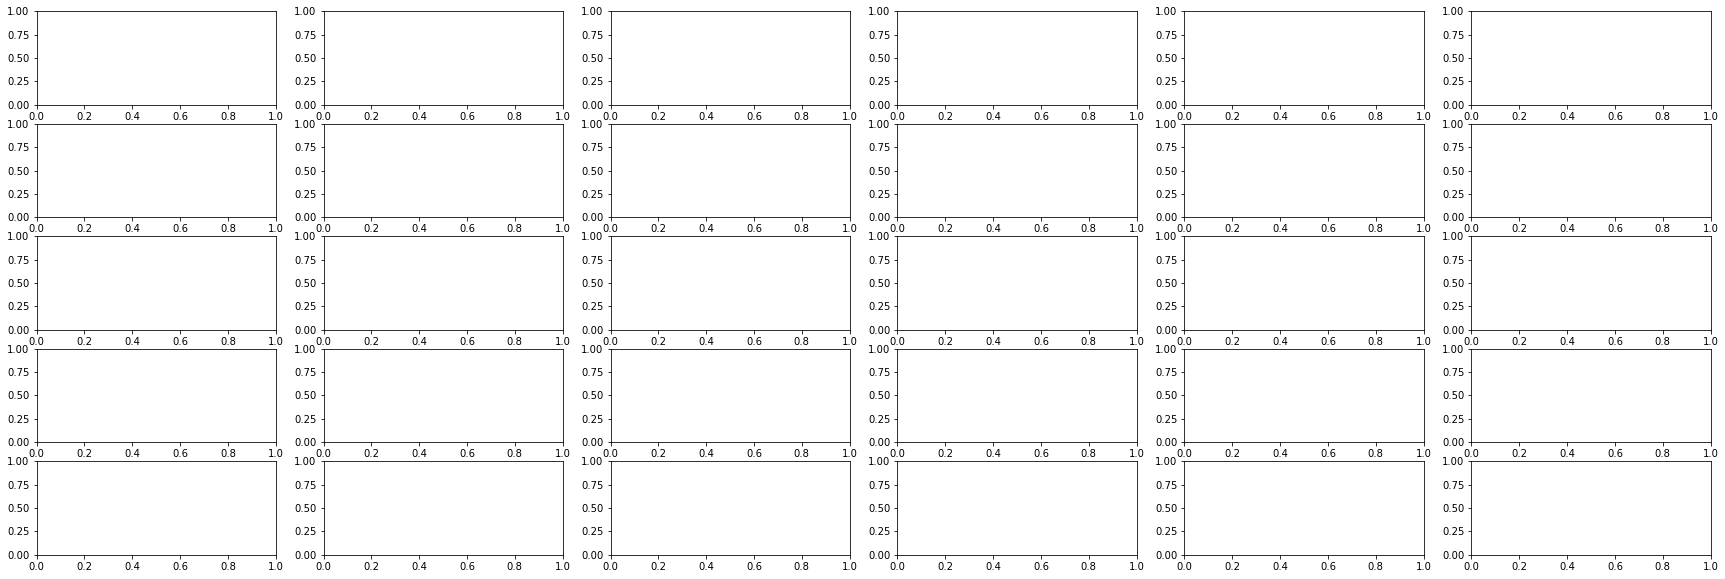

In [61]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(30,10))

for i in range(len(features)):
    row = int(i/6)
    col = i%6
    
    axes[row,col] = sns.distplot(df[features[i]], ax = axes[row,col])
    axes[row,col].set_xticks([])


## Investigating our features correlation to our target

In [ ]:
from beakerx.object import beakerx
beakerx.pandas_display_table()
most_correlated = corr.abs()['CLASS_RESULT'].sort_values(ascending=False).reset_index()
most_correlated = most_correlated.iloc[1:].rename({"index":"feature","CLASS_RESULT":"correlation_to_target"}, axis = 1)
print(most_correlated)

# Fantastic!
<blockquote> 
We've just demonstrated our platform's ability to execute simple feature investigation routines <br>
    Next Up: <a href='./7.4 Feature Engineering.ipynb'>Using MLManager to Engineer Features</a>
<footer>Splice Machine</footer>
</blockquote>